In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from scipy.stats import norm

In [27]:
import pandas as pd

# Load all 3 days of data
day0 = pd.read_csv("/Users/jessi/Desktop/prosperity-3/round3/data/prices_round_3_day_0.csv", delimiter=";")
day1 = pd.read_csv("/Users/jessi/Desktop/prosperity-3/round3/data/prices_round_3_day_1.csv", delimiter=";")
day2 = pd.read_csv("/Users/jessi/Desktop/prosperity-3/round3/data/prices_round_3_day_2.csv", delimiter=";")

# Combine all into one DataFrame
all_data = pd.concat([day0, day1, day2], ignore_index=True)
all_data.head()

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,0,0,VOLCANIC_ROCK_VOUCHER_10500,99.0,19.0,NaN,NaN,NaN,NaN,100,19,NaN,NaN,NaN,NaN,99.5,0.0
1,0,0,DJEMBES,13493.0,72.0,NaN,NaN,NaN,NaN,13494,72,NaN,NaN,NaN,NaN,13493.5,0.0
2,0,0,CROISSANTS,4321.0,111.0,NaN,NaN,NaN,NaN,4322,111,NaN,NaN,NaN,NaN,4321.5,0.0
3,0,0,JAMS,6631.0,210.0,NaN,NaN,NaN,NaN,6633,210,NaN,NaN,NaN,NaN,6632.0,0.0
4,0,0,VOLCANIC_ROCK_VOUCHER_10000,505.0,19.0,NaN,NaN,NaN,NaN,506,19,NaN,NaN,NaN,NaN,505.5,0.0


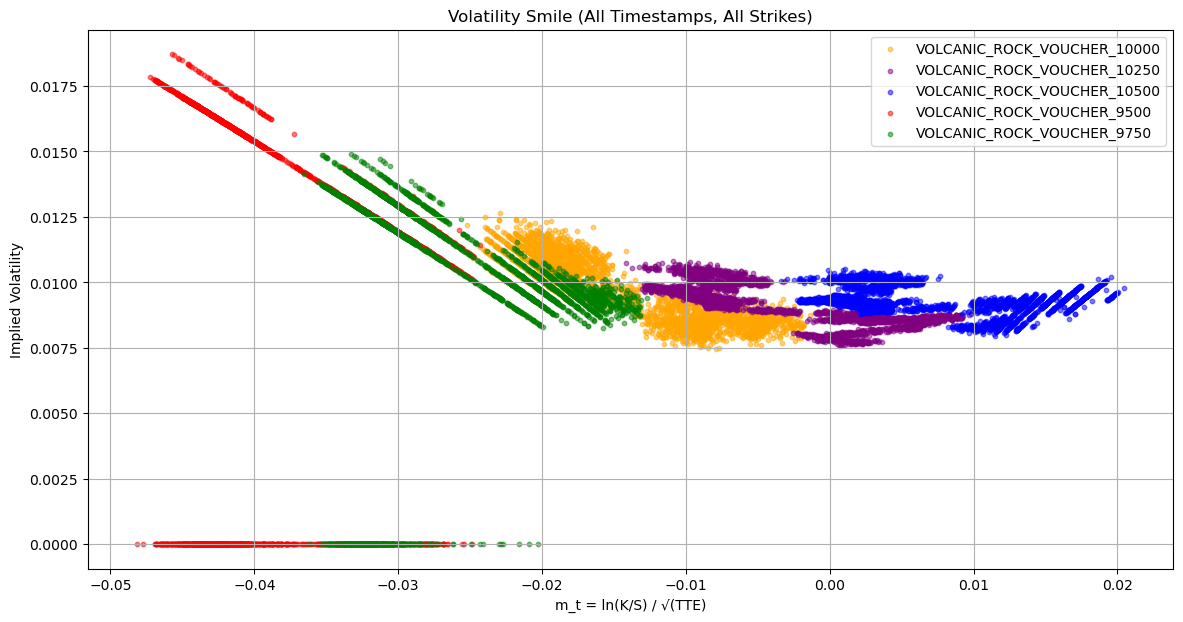

In [28]:
def bs_call_price(S, K, T, r, sigma):
    if T <= 0 or sigma <= 0:
        return max(S - K, 0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

def implied_volatility_call(S, V_market, K, T, r):
    try:
        return brentq(lambda sigma: bs_call_price(S, K, T, r, sigma) - V_market, 1e-6, 5.0)
    except Exception:
        return np.nan

# Constants
T = 5
r = 0
voucher_prefix = "VOLCANIC_ROCK_VOUCHER"
strike_products = sorted([p for p in all_data['product'].unique() if voucher_prefix in p and p != "VOLCANIC_ROCK"])

# Manually assign colors to each strike product
color_map = {
    "VOLCANIC_ROCK_VOUCHER_9500": "red",
    "VOLCANIC_ROCK_VOUCHER_9750": "green",
    "VOLCANIC_ROCK_VOUCHER_10000": "orange",
    "VOLCANIC_ROCK_VOUCHER_10250": "purple",
    "VOLCANIC_ROCK_VOUCHER_10500": "blue"
}

# Plot
plt.figure(figsize=(14, 7))

for product in strike_products:
    if product not in color_map:
        continue  # Skip any unassigned ones

    K = int(product.split("_")[-1])
    strike_df = all_data[all_data['product'] == product]
    underlying_df = all_data[all_data['product'] == "VOLCANIC_ROCK"]

    merged = pd.merge(
        strike_df[['day', 'timestamp', 'mid_price']],
        underlying_df[['day', 'timestamp', 'mid_price']],
        on=['day', 'timestamp'], suffixes=('_option', '_underlying')
    )

    merged = merged[(merged['mid_price_underlying'] > 0) & (merged['mid_price_option'] > 0)]
    merged = merged.iloc[::10].copy()  # Sample for speed

    merged['implied_vol'] = merged.apply(lambda row:
        implied_volatility_call(row['mid_price_underlying'], row['mid_price_option'], K, T, r), axis=1)
    merged['moneyness'] = np.log(K / merged['mid_price_underlying']) / np.sqrt(T)

    plt.scatter(merged['moneyness'], merged['implied_vol'], s=10, alpha=0.5,
                label=product, color=color_map[product])

plt.xlabel("m_t = ln(K/S) / √(TTE)")
plt.ylabel("Implied Volatility")
plt.title("Volatility Smile (All Timestamps, All Strikes)")
plt.legend()
plt.grid(True)
plt.show()